### Градиентный бустинг

В данном задании мы изучим применение градиентного бустинга для решения реальных задач.
  
Мы будем использовать данные об аренде квартир сервиса Яндекс.Недвижимость: по информации из объявления предсказывать время его экспозиции на сервисе.  

Метрикой качества для в данном задании является средняя абсолютная ошибка, MAE.

In [ ]:
! wget https://www.dropbox.com/s/psutl0zafq50828/data.tsv > ./data.tsv

In [2]:
! pip install catboost==0.24.4
! pip install lightgbm==2.3.1

     |████████████████████████████████| 65.7 MB 37.7 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 673 kB/s  eta 0:00:01


In [3]:
import pandas as pd
import catboost
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

data = pd.read_csv('./data.tsv', sep='\t')
num_features = ['agent_fee', 'floor', 'floors_total', 'kitchen_area', 'living_area', 'price', 'rooms_offered', 'total_area', 'total_images']
cat_features = ['balcony', 'building_type', 'month', 'renovation', 'studio']

X_train, X_test, y_train, y_test = train_test_split(data[num_features+cat_features], data['exposition_time'], test_size=0.3, shuffle=False)

__Задание 1.__

Обучите реализации градиентного бустинга LightGBM и Catboost на **вещественных** признаках без подбора параметров. Данная задача является задачей регрессии, поэтому используйте соответствующие модели бустинга. Сделайте предсказания для тестовой выборки, посчитайте MAE. Выведите модуль разности между значениями метрик LightGBM и Catboost.

В этом и последующих экспериментах измерьте время обучения моделей.

In [5]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [20]:
%%time

catboost_clf = CatBoostRegressor(logging_level='Silent', task_type='GPU')
catboost_clf.fit(X_train[num_features], y_train)

catboost_predict = catboost_clf.predict(X_test[num_features])
mean_absolute_error(catboost_predict, y_test)

CPU times: user 4.9 s, sys: 980 ms, total: 5.88 s
Wall time: 4.47 s


37.81024887094167

In [11]:
%%time

lightgbm_clf = LGBMRegressor()
lightgbm_clf.fit(X_train[num_features], y_train)

lightgbm_predict = lightgbm_clf.predict(X_test[num_features])
mean_absolute_error(lightgbm_predict, y_test)

CPU times: user 3.47 s, sys: 93.6 ms, total: 3.56 s
Wall time: 1.18 s


36.49859872052625

__Задание 2.__

Подберите оптимальные параметры для Catboost на вещественных признаках,  используя все доступные комбинации из:

* глубины деревьев {5, 7, 9};
* темпа обучения {0.05, 0.1, 0.5}.

Можно использовать GridSearchCV или реализовать перебор самостоятельно.

В качестве оптимизируемого функционала в алгоритме используйте MAE (loss_function='MAE'), random_seed=0, другие параметры оставьте без изменений.

**Сделайте предсказания для тестовой выборки лучшей моделью, вычислите MAE.**

In [16]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(
    estimator=CatBoostRegressor(loss_function='MAE', random_seed=0, logging_level='Silent'),
    param_grid={
        'depth': [5, 7, 9],
        'learning_rate': [0.05, 0.1, 0.5],
    }
)

In [17]:
clf.fit(X_train[num_features], y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f741f4efe50>,
             iid='deprecated', n_jobs=None,
             param_grid={'depth': [5, 7, 9], 'learning_rate': [0.05, 0.1, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
mean_absolute_error(clf.predict(X_test[num_features]), y_test)

31.701428038959534

__Задание 3.__

Пока что мы использовали только вещественные данные, однако категориальные переменные также могут быть полезны для решения задачи. Перебирая комбинации параметров из предыдущего пункта, используйте все доступные признаки, обрабатывая категориальные встроенным методом Catboost (для этого их нужно указать параметром cat_features).

Выведите значение MAE на тестовой выборке для лучшей модели.

In [21]:
cv_clf = GridSearchCV(
    estimator=CatBoostRegressor(
        loss_function='MAE',
        random_seed=0,
        logging_level='Silent',
        task_type="GPU", # оооочень долго на CPU считать
        cat_features=cat_features
    ),
    param_grid={
        'depth': [5, 7, 9],
        'learning_rate': [0.05, 0.1, 0.5],
    }
)
cv_clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f741e2ecd30>,
             iid='deprecated', n_jobs=None,
             param_grid={'depth': [5, 7, 9], 'learning_rate': [0.05, 0.1, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [22]:
mean_absolute_error(cv_clf.predict(X_test), y_test)

35.10428404180379

__Задание 4.__

Реализуйте блендинг (получение ответов нескольких моделей и взятие их с весами (их нужно подбирать на обучающей выборке)) полученных в заданиях 2 и 3 моделей и выведите MAE на тестовой выборке.

Для этого можно использовать LinearRegression на двух векторах предсказаний этих моделей с параметром fit_intercept=False, таким образом будет найдена наилучшая линейная комбинация двух моделей.

In [31]:
from sklearn.linear_model import LinearRegression
import numpy as np

x1 = cv_clf.predict(X_train)
x2 = clf.predict(X_train[num_features])
y = y_train

lin_reg_clf = LinearRegression(fit_intercept=False)
lin_reg_clf.fit(np.transpose([x1, x2]), y)

x1 = cv_clf.predict(X_test)
x2 = clf.predict(X_test[num_features])
y = y_test

mean_absolute_error(lin_reg_clf.predict(np.transpose([x1, x2])), y)

33.77303252509625

__Задание 5.__

В задании 3 вы подобрали гиперпараметры для CatBoost на всех признаках. Визуализируйте их важности в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (значения менее 0.05; обычно по bar-plot хорошо видно порог, с которого начинается хвост неважных признаков) и обучите модель с теми же параметрами на оставшихся признаках. Выведите разность между значениями MAE на тестовой выборке до и после удаления признаков.

0.0


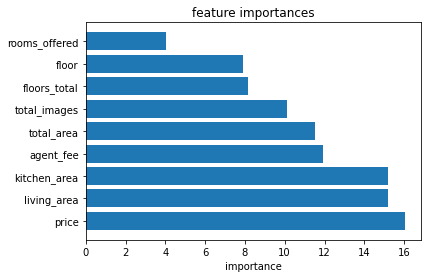

In [118]:
n_cols = zip(
    clf.best_estimator_.get_feature_importance(),
    X_test.columns, 
)
n_cols = sorted(n_cols, reverse=True)

x, y = zip(*n_cols)
plt.barh(y, x, align='center')
plt.xlabel('importance')
plt.title('feature importances')

mae_1_before = mean_absolute_error(clf.predict(X_test[num_features]), y_test)
mae_1_after = mae_1_before
print(mae_1_before - mae_1_after)

-0.12544116041770081


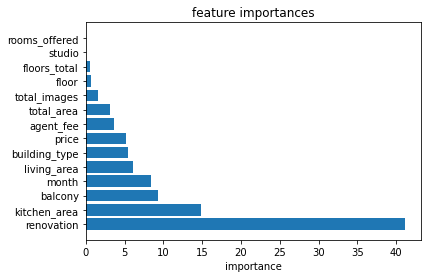

In [117]:
import matplotlib.pyplot as plt

n_cols = zip(
    cv_clf.best_estimator_.get_feature_importance(),
    X_test.columns, 
)
n_cols = sorted(n_cols, reverse=True)

x, y = zip(*n_cols)
plt.barh(y, x, align='center')
plt.xlabel('importance')
plt.title('feature importances')

important_features = list(y[:-2])

cat_important_features = []
for i in cat_features:
    if i in important_features:
        cat_important_features.append(i)

num_important_features = []
for i in num_features:
    if i in important_features:
        num_important_features.append(i)

mae_2_before = mean_absolute_error(cv_clf.predict(X_test), y_test)

new_cv_clf = CatBoostRegressor(
    loss_function='MAE',
    random_seed=0,
    logging_level='Silent',
    task_type="GPU", # оооочень долго на CPU считать
    cat_features=cat_important_features,
    ** cv_clf.best_params_

)
new_cv_clf.fit(X_train[important_features], y_train)

mae_2_after = mean_absolute_error(new_cv_clf.predict(X_test[important_features]), y_test)
print(mae_2_before - mae_2_after)